In [42]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


def recall_k(k,test,train,res):
    return [np.mean([float(np.intersect1d(res[x][:k],test[test[:,0]==x,1]).size)/test[test[:,0]==x,1].size \
                     for x in xrange(res.shape[0]) if test[test[:,0]==x,1].size > 0]) ]

def recall_k_df(k,test,train,res):
    data=[(k,test[test[:,0]==x,1].size,float(np.intersect1d(res[x][:k],test[test[:,0]==x,1]).size)/test[test[:,0]==x,1].size) for x in xrange(res.shape[0])]
    p=pd.DataFrame(data,columns=['m','n_rel_items','recall_m_rel_items'])
    return p
    
def results_k(k,test,res):
        eval_list=[]
        test=test.astype(int)   
        for i in xrange(res.shape[0]):
                relevant = test[test[:,0]==i,1]
                retrieved_k = np.array(sorted(zip(res[i],xrange(res[i].size)),reverse=True))[:k,1].astype(int)
                relevant_retrieved=np.intersect1d(relevant,retrieved_k)
                eval_list.append([relevant_retrieved.size/float(relevant.size),relevant_retrieved.size/float(k)])
        return np.mean(eval_list,axis=0)
    
def results_k_without_train(k,test,train,res):
        eval_list=[]
        test=test.astype(int)   
        for i in xrange(res.shape[0]):
                relevant = test[test[:,0]==i,1]
                known_items = train[train[:,0]==i,1]
                scores_user_i=np.array(res[i])
                scores_user_i[known_items]=-np.inf
                retrieved_k = scores_user_i.argsort()[::-1][:k]
                relevant_retrieved=np.intersect1d(relevant,retrieved_k)
                recall_without_train=relevant_retrieved.size/float(relevant.size)
                
                retrieved_k = res[i].argsort()[::-1][:k]
                relevant_retrieved=np.intersect1d(relevant,retrieved_k)
                recall_with_train=relevant_retrieved.size/float(relevant.size)
                eval_list.append([recall_without_train,recall_with_train])
        return np.mean(eval_list,axis=0)
    
def genGraphRes(folder,res_files):
    test=np.loadtxt(folder+'user_artist_rating.test')
    summary_res=dict()
    for experiment in res_files:
        print "experiment: "+experiment
        res=np.loadtxt(folder+experiment)
        exps=np.vstack((np.hstack((results_k(M,test,res),[M])) for M in [50, 100, 150, 200, 250]))
        p=pd.DataFrame(exps,columns=['recall@m','precision_at_m','m'])
        p.plot(x='m')
        plt.show()
        summary_res[experiment]=p
    return summary_res

def genGraphRes_recall(folder,res_files):
    test=np.loadtxt(folder+'user_artist_rating.test').astype(int)
    train=np.loadtxt(folder+'user_artist_rating.train').astype(int)
    summary_res=dict()
    for experiment in res_files:
        print "experiment: "+experiment
        res=np.loadtxt(folder+experiment)
        exps=np.vstack((np.hstack((results_k_without_train(M,test,train,res),[M])) for M in [50, 100, 150, 200, 250]))
        p=pd.DataFrame(exps,columns=['recall@m','precision_at_m','m'])
        p.plot(x='m')
        plt.show()
        summary_res[experiment]=p
    return summary_res

def genGraphRes_recall_resrec(folder_dataset,res_files,folder_result=None,m_vals=[50, 100, 150, 200, 250],is_plot=True):
    if(folder_result==None):
        folder_result=folder_dataset
    print "dataset folder: ",folder_dataset
    test=np.loadtxt(folder_dataset+'user_artist_rating.test').astype(int)
    train=np.loadtxt(folder_dataset+'user_artist_rating.train').astype(int)
    summary_res=dict()
    list_res=[]
    for experiment in res_files:
        print "experiment: "+experiment
        print "loading "+folder_result+experiment
        res=np.loadtxt(folder_result+experiment)
        exps=np.vstack((np.hstack((recall_k(M,test,train,res),[M])) for M in m_vals))
        p=pd.DataFrame(exps,columns=['recall@m','m'])
        if(is_plot):
            p.plot(x='m')
            plt.show()
        summary_res[experiment]=p
    return summary_res


def genGraphRes_recall_folders(res_files,m_vals=[50, 100, 150, 200, 250],is_plot=True,log_print=True):
    
    summary_res=dict()
    list_res=[]
    for experiment in res_files:
        
        folder_dataset = experiment.split("experiment_")[0]
        if(log_print):
            "dataset folder: ",folder_dataset
        test=np.loadtxt(folder_dataset+'user_artist_rating.test').astype(int)
        train=np.loadtxt(folder_dataset+'user_artist_rating.train').astype(int)
        if(log_print):
            print "experiment: "+experiment.split("experiment_")[1]
            print "loading "+experiment
        res=np.loadtxt(experiment)
        exps=np.vstack((np.hstack((recall_k(M,test,train,res),[M])) for M in m_vals))
        p=pd.DataFrame(exps,columns=['recall@m','m'])
        if(is_plot):
            p.plot(x='m')
            plt.show()
        summary_res[folder_dataset.split('/')[-2]+"_"+experiment.split("experiment_")[1]]=p
    return summary_res


def recall_folders_single(experiment,m_vals=[50, 100, 150, 200, 250],log_print=True):
    
    list_res=[]
    m_str=['recall_m'+str(m) for m in m_vals]
    folder_dataset = experiment.split("experiment_")[0]
    if(log_print):
        "dataset folder: ",folder_dataset
    test=np.loadtxt(folder_dataset+'user_artist_rating.test').astype(int)
    train=np.loadtxt(folder_dataset+'user_artist_rating.train').astype(int)
    if(log_print):
        print "experiment: "+experiment.split("experiment_")[1]
        print "loading "+experiment
    res=np.loadtxt(experiment)
    exps=zip(m_str,[recall_k(M,test,train,res) for M in m_vals])
    return exps

baseline_pd=pd.DataFrame()
baseline_pd['CTR-SMF']=[0.17,0.28,0.36,0.435,0.48]
baseline_pd['CTR']=[0.165,0.26,0.34,0.41,0.46]
baseline_pd['PMF']=[0.16,0.25,0.33,0.4,0.45]
def plotCompare(datax,baseline_vals,name='PoissonTopicSocial'):
    dataf=pd.DataFrame()
    dataf[name]=datax['recall_at_m (filter_train)']
    dataf['m']=datax['m']
    dataf['CTR-SMF']=baseline_vals['CTR-SMF']
    dataf['CTR']=baseline_vals['CTR']
    dataf['PMF']=baseline_vals['PMF']
    dataf.plot(x='m')
    plt.show()
    return dataf

def plotListCompare(datax,baseline_vals,names,threshold=0.47,do_plot=True,log_print=True):
    dataf=pd.DataFrame()
    dataf['CTR-SMF']=baseline_vals['CTR-SMF']
    dataf['CTR']=baseline_vals['CTR']
    dataf['PMF']=baseline_vals['PMF']
    for key in datax:
        if np.array(datax[key][datax[key].m==250]['recall_at_m (filter_train)']>threshold)[0]:
            if(log_print):
                print "file=",key,"id=",names[key]
            dataf[names[key]]=datax[key]['recall_at_m (filter_train)']
            dataf['m']=datax[key]['m']
    if(do_plot):
        plt.figure(figsize=(200,200))
        dataf.plot(x='m',linestyle='-', marker='x')
        #plt.show()
        plt.savefig('/home/eliezer/plot_out.png')
    return dataf

def load_test_train(folder='/home/eliezer/datasets/hetrec2011/lastfm/p85_train_test_9208/'):
    test=np.loadtxt(folder+'user_artist_rating.test').astype(int)
    train=np.loadtxt(folder+'user_artist_rating.train').astype(int)
    return (test,train)

In [5]:
#folder='/home/eliezer/datasets/hetrec2011/lastfm/p85_train_test_9208/'
#res_files = !ls long_experiments/experiment_w*.rec
#summary_long=genGraphRes_recall_resrec(folder,res_files,is_plot=False)

#cmp_data2=plotListCompare(summary_long_laptop,baseline_pd,idnames_lap,threshold=0.45)
def plotall_summary_dataf(summary_long,kcol_str,boxplot=False):
    data_cmp5=plotListCompare(summary_long,baseline_pd,\
                         dict(zip(summary_long.keys(),\
                                  [x.split("_")[5]+'_'+x.split("_")[3] for x in summary_long.keys()])),\
                         0.3,log_print=False,do_plot=False)
    data_cmp5['k_err']=data_cmp5[[x for x in data_cmp5.columns if x.startswith(kcol_str)]].std(axis=1)
    data_cmp5['PoissonMF-CS']=data_cmp5[[x for x in data_cmp5.columns if x.startswith(kcol_str)]].mean(axis=1)
    plotErrorBar_data_cmp(data_cmp5,boxplot)
    return data_cmp5

#cmp_data2=plotListCompare(summary_long_laptop,baseline_pd,idnames_lap,threshold=0.45)
def plotall_summary_dataf_vark(summary_long,lstK,suffix_str):
    data_cmp=plotListCompare(summary_long,baseline_pd,\
                         dict(zip(summary_long.keys(),\
                                  [suffix_str+str(x) for x in lstK])),\
                         0.3,log_print=False,do_plot=False)
    newfrm=data_cmp[[suffix_str+str(x) for x in lstK]]
    newfrm.index = data_cmp['m']
    axs=newfrm.plot(linestyle='-', marker='p')
    return data_cmp

def plotErrorBar_data_cmp(data_cmp,boxplot=False):
    newfrm=data_cmp[['PoissonMF-CS','CTR-SMF', 'CTR', 'PMF']]
    x=data_cmp['m']
    ma = data_cmp['PoissonMF-CS'].values
    mstd = data_cmp['k_err']
    plt.figure()
    if(boxplot):
        x=data_cmp['m'].index+1
    newfrm.index = x
    axs=newfrm.plot(linestyle='-', marker='p')
    axs.set_xlabel('# returned items (m)')
    axs.set_ylabel('Avg. recall@M')
    if(boxplot):
        temp=data_cmp[[x for x in data_cmp.columns if x.startswith('k')]]
        temp['m']=data_cmp['m']
        res_dic=temp.pivot_table(cols=['m']).boxplot(ax=axs)
    else:
        plt.fill_between(x, ma-2*mstd, ma+2*mstd, color='b', alpha=0.2)
    x1,x2,y1,y2 = plt.axis()

    plt.axis((x1,x2,.15,.55))

In [14]:
def plotCompareSameExpErrorBar_data_cmp(data_cmp_lst,legends=None):
    plt.figure()
    c=0
    for data_cmp in data_cmp_lst:
        x = data_cmp['m']
        ma = data_cmp['PoissonMF-CS'].values
        mstd = data_cmp['k_err']
        strlabel='exp '+str(c) if legends == None else legends[c]
        plt.plot(x,ma,linestyle='-',label=strlabel, marker='p')
        plt.fill_between(x, ma-mstd, ma+mstd,alpha=0.2)
        c+=1
    plt.legend(loc=0)
    
def plot_var_k_m(data_cmp7,m,ax=None):
    r_vals=np.array(data_cmp7[data_cmp7['m']==m][[x for x in data_cmp7.columns if x.startswith('PoissonMF-CS')]])
    k_vals=np.array([[int(x.split('=')[1]) for x in data_cmp7.columns if x.startswith('PoissonMF-CS')]])
    data_res=pd.DataFrame(np.hstack((r_vals.T,k_vals.T)),\
             columns=['recall@'+str(m),'#latent factors (k)'])
    if(ax==None):
        ax=data_res.plot(x='#latent factors (k)',linestyle='-',marker='p')
    else:
        ax=data_res.plot(x='#latent factors (k)',linestyle='-',marker='p',ax=ax)
    return (ax,data_res)

def pivot_n_table_var_contw_socw(exp11_summary):
    exp11_df_all = pd.DataFrame()
    for key in exp11_summary.keys():
        #temp0=exp11_summary[key]
        #temp0['m']=['m='+str(x) for x in temp0['m']]
        temp=exp11_summary[key].pivot_table(columns='m')
        temp.index=[key]
        temp['contw']=[float(key.split('contw')[1].split('_')[0])]
        temp['socw']=[float(key.split('socw')[1].split('_')[0])]
        exp11_df_all=exp11_df_all.append(temp)
    return exp11_df_all

In [15]:
from matplotlib.mlab import griddata

def plot2dcontour_summary_var_contw_socw_rotate(temp_mean,log_xy=False,m=50,fname=None):
    x=temp_mean.contw.values.astype(float)
    y=temp_mean.socw.values.astype(float)
    z=temp_mean[m].values

    fig=plt.figure()
    ax=plt.subplot()
    xi=np.linspace(np.min(x),np.max(x),100)
    yi=np.linspace(np.min(y),np.max(y),200)
    X,Y= np.meshgrid(xi,yi)
    #Z = griddata((x, y), z, (X, Y),method='nearest')
    Z = griddata(x, y, z, X, Y)
    surf=plt.contourf(X,Y,Z)
    cbar=fig.colorbar(surf, shrink=0.5, aspect=5)
    cbar.set_label("recall@m="+str(m))
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    if(log_xy):
        ax.set_xscale("log", nonposx='clip')
        ax.set_yscale("log", nonposy='clip')
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')

In [16]:
matplotlib.rc('text', usetex=False)

def plot3d_summary_var_contw_socw(temp_mean,m=50,fname=None):
    X=temp_mean.contw.values.astype(float)
    Y=temp_mean.socw.values.astype(float)
    Z=temp_mean[m].values
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    surf=ax.plot_trisurf(X,Y,Z,cmap=cm.coolwarm)
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    ax.set_zlabel('Avg recall at '+str(m))
    #ax.view_init(elev=6, azim=300)

    #ax.set_xlabel('#latent factors (k)')
    #ax.set_ylabel('# returned items (m)')
    #ax.set_zlabel('Avg recall@m')

    fig.colorbar(surf, shrink=0.5, aspect=5)
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')

    plt.show()

def plot3d_summary_var_contw_socw_rotate(temp_mean,m=50,angle=250,elev1=6,fname=None):
    X=temp_mean.contw.values.astype(float)+0.000000000001
    Y=temp_mean.socw.values.astype(float)
    Z=temp_mean[m].values
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_xscale('log')
    surf=ax.plot_trisurf(X,Y,Z,cmap=cm.coolwarm)
    ax.view_init(elev=elev1, azim=angle)
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    ax.set_zlabel('Avg recall at '+str(m))
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
        
        
def plot3dcontour_summary_var_contw_socw_rotate(temp_mean,m=50,angle=250,elev1=6,fname=None):
    X=temp_mean.contw.values.astype(float)+0.000000000001
    Y=temp_mean.socw.values.astype(float)
    Z=temp_mean[m].values
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_xscale('log')
    surf=ax.tricontour(X,Y,Z,cmap=cm.coolwarm)
    ax.view_init(elev=elev1, azim=angle)
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    ax.set_zlabel('Avg recall at '+str(m))
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
    
        
def plot3dscatter_summary_var_contw_socw_rotate(temp_mean,m=50,angle=250,elev1=6,fname=None):
    X=temp_mean.contw.values.astype(float)+0.00000000001
    Y=temp_mean.socw.values.astype(float)
    Z=temp_mean[m].values
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_xscale('log')
    surf=ax.scatter3D(X,Y,Z,c=Z,cmap=cm.coolwarm)
    ax.view_init(elev=elev1, azim=angle)
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    ax.set_zlabel('Avg recall at '+str(m))
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
        


def plothexbin_summary_var_contw_socw(temp_mean,m=250,gridsize=4,fname=None):
    X=temp_mean.contw.values.astype(float)+0.0000000001
    Y=temp_mean.socw.values.astype(float)+0.0000000001
    Z=temp_mean[m].values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hexbin(X, Y, C=Z,yscale='log',xscale='log',gridsize=gridsize, cmap=cm.jet, bins=None)
    #plt.hexbin(X, Y, C=Z,gridsize=gridsize, cmap=cm.jet)
    plt.axis([X.min(), X.max(), Y.min(), Y.max()])
    cb = plt.colorbar()
    cb.set_label('Avg recall at '+str(m))
    ax.set_xlabel(r'content $\lambda_C$')
    ax.set_ylabel(r'social $\lambda_S$')
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
    plt.show()
    
    
def plothexbin_summary_cols(temp_mean,cols,gridsize=4,fname=None):
    X=temp_mean[cols[0]].values.astype(float)+0.0000000001
    Y=temp_mean[cols[1]].values.astype(float)+0.0000000001
    Z=temp_mean[cols[2]].values

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hexbin(X, Y, C=Z,yscale='log',xscale='log',gridsize=gridsize, cmap=cm.jet, bins=None)
    #plt.hexbin(X, Y, C=Z,gridsize=gridsize, cmap=cm.jet)
    plt.axis([X.min(), X.max(), Y.min(), Y.max()])
    cb = plt.colorbar()
    cb.set_label(cols[2])
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
    plt.show()
    
    
def plot3dscatter_summary_rotate(temp_mean,cols,angle=50,elev1=6,fname=None):
    X=temp_mean[cols[0]].values.astype(float)
    Y=temp_mean[cols[1]].values.astype(float)
    Z=temp_mean[cols[2]].values
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.set_xscale('log')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    surf=ax.scatter3D(X,Y,Z,c=Z,cmap=cm.coolwarm)
    ax.view_init(elev=elev1, azim=angle)
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    ax.set_zlabel(cols[2])
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')
        
def plot2d_summary_cols_rotate(temp_mean,cols,log_xy=False,labels=None,fname=None):
    if(labels==None):
        labels=cols

    x=temp_mean[cols[0]].values.astype(float)
    y=temp_mean[cols[1]].values.astype(float)

    z=temp_mean[cols[2]].values
    fig = plt.figure()
    ax=plt.subplot()
    xi=np.linspace(np.min(x),np.max(x),200)
    yi=np.linspace(np.min(y),np.max(y),200)
    X,Y= np.meshgrid(xi,yi)
    Z = griddata(x, y, z, X, Y)
    surf=plt.contourf(X,Y,Z)
    cbar=fig.colorbar(surf, shrink=0.5, aspect=5)
    cbar.set_label(labels[2])
    if(log_xy):
        ax.set_xscale("log", nonposx='clip')
        ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    #ax.set_zlabel(labels[2])
    if (fname!=None):
        plt.savefig(fname, bbox_inches='tight')

In [43]:
exp1_files=!./get_entity_log.sh delicious_long_experiment1_vark_learnw_d2981_p85 "##results_file" "#time"
exp1_files=[[x.split("|")[0],float(x.split("|")[0].split('contw')[1].split('_')[0]),\
              float(x.split("|")[0].split('socw')[1].split('_')[0]),\
              int(x.split("|")[1].split(" ")[0])] for x in exp1_files if x.split("|")[1]!='']
exp1_files=pd.DataFrame(exp1_files, columns=['rec','contw','socw','time(s)'])
#exp1_summary=genGraphRes_recall_folders(exp1_files.rec.values,is_plot=False,log_print=True)

experiment: wlearn_k5_it40_tol5_contw1923.40_socw0.00_nrec1000_ha0.10_hb0.10.rec
loading /home/eliezer/Dropbox/repo-phd/poissoncpp/datasets/hetrec2011/delicious/p85_train_test_4941/experiment_wlearn_k5_it40_tol5_contw1923.40_socw0.00_nrec1000_ha0.10_hb0.10.rec
experiment: wlearn_k10_it40_tol5_contw4370.53_socw0.00_nrec1000_ha0.10_hb0.10.rec
loading /home/eliezer/Dropbox/repo-phd/poissoncpp/datasets/hetrec2011/delicious/p85_train_test_4941/experiment_wlearn_k10_it40_tol5_contw4370.53_socw0.00_nrec1000_ha0.10_hb0.10.rec
experiment: wlearn_k15_it40_tol5_contw4741.03_socw0.00_nrec1000_ha0.10_hb0.10.rec
loading /home/eliezer/Dropbox/repo-phd/poissoncpp/datasets/hetrec2011/delicious/p85_train_test_4941/experiment_wlearn_k15_it40_tol5_contw4741.03_socw0.00_nrec1000_ha0.10_hb0.10.rec


In [ ]:
exp1_summary

In [105]:
exp1_files=!./get_entity_log.sh long_experiment13_fixedk10_constw_varlambda_1dataset8716_p85 "##results_file" "#time"
exp1_files=[[x.split("|")[0],float(x.split("|")[0].split('contw')[1].split('_')[0]),\
              float(x.split("|")[0].split('socw')[1].split('_')[0]),\
              int(x.split("|")[1].split(" ")[0])] for x in exp1_files if x.split("|")[1]!='']
exp1_files=pd.DataFrame(exp1_files, columns=['rec','contw','socw','time(s)'])

experiment: wconst_k10_it40_tol5_contw0.00_socw0.00_nrec1000_ha0.10_hb0.10.rec
loading /home/eliezer/Dropbox/repo-phd/poissoncpp/datasets/hetrec2011/lastfm/p85_train_test_8716/experiment_wconst_k10_it40_tol5_contw0.00_socw0.00_nrec1000_ha0.10_hb0.10.rec


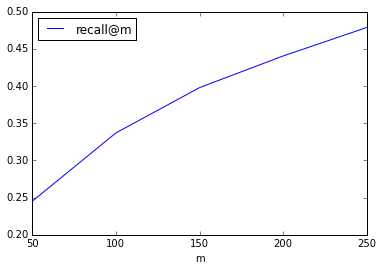

experiment: wconst_k10_it40_tol5_contw0.00_socw0.01_nrec1000_ha0.10_hb0.10.rec
loading /home/eliezer/Dropbox/repo-phd/poissoncpp/datasets/hetrec2011/lastfm/p85_train_test_8716/experiment_wconst_k10_it40_tol5_contw0.00_socw0.01_nrec1000_ha0.10_hb0.10.rec


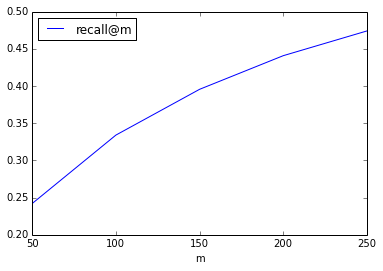

In [106]:

res_files=exp1_files.rec[0:2].values
m_vals=[50, 100, 150, 200, 250]
is_plot=True
log_print=True
    
summary_res=dict()
list_res=[]
for experiment in res_files:

    folder_dataset = experiment.split("experiment_")[0]
    if(log_print):
        "dataset folder: ",folder_dataset
    test=np.loadtxt(folder_dataset+'user_artist_rating.test').astype(int)
    train=np.loadtxt(folder_dataset+'user_artist_rating.train').astype(int)
    if(log_print):
        print "experiment: "+experiment.split("experiment_")[1]
        print "loading "+experiment
    res=np.loadtxt(experiment)
    exps=np.vstack((np.hstack((recall_k(M,test,train,res),[M])) for M in m_vals))
    p=pd.DataFrame(exps,columns=['recall@m','m'])
    if(is_plot):
        p.plot(x='m')
        plt.show()
    summary_res[folder_dataset.split('/')[-2]+"_"+experiment.split("experiment_")[1]]=p

In [107]:
n=9
print np.intersect1d(test[test[:,0]==n],res[n].astype(int))
print np.intersect1d(train[train[:,0]==n],res[n].astype(int))

[247 282 286 451 468 473 478 537]
[ 243  251  264  293  306  314  336  424  441  521  956 1235 1500]
